In [10]:
import osmnx as ox
import pandas as pd
import geopandas as gdp

import numpy as np
import networkx as nx
import os
import sys
import pickle
import re

from shapely.geometry import Polygon, MultiPolygon
from descartes import PolygonPatch

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib import ticker
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors

from sklearn import cluster

prjDir = "/home/charles/Projects/QcMtlStreets"
sys.path.append(os.path.join(prjDir, "Python"))   
os.path.isdir(os.path.join(prjDir, "Python"))
from OsmnxElev import *

In [11]:
listNeighAll5=["Saint-Jean-Baptiste", 
               "Saint-Roch" ,
              "Vieux-Québec/Cap-Blanc/Colline parlementaire",
              "Saint-Sauveur",
              "Montcalm"]

In [12]:
#Get the graph

In [13]:
graphQcAll5, shpQchAll5, dfPointsSubsetQchAll5 = getInducedSubgraphNeighQc(listNeighAll5)
print(type(graphQcAll5))

File exists => reading graph
There are  0.17462765309849437  of points in the bounding box in neighbourhoods Saint-Jean-Baptiste, Saint-Roch, Vieux-Québec/Cap-Blanc/Colline parlementaire, Saint-Sauveur, Montcalm
<class 'networkx.classes.multidigraph.MultiDiGraph'>


In [14]:
#Tests with adjacency matrix

In [15]:
adjMatrixQcAll5 = getAdjMatrixFromGraph(graphQcAll5,weightCol=None)
adjMatrixQcAll5.shape

Warning in getAdjMatrixFromGraph: adj matrix is not symmetric


(9807, 9807)

In [16]:
adjMatrixQcAll5V2=nx.adjacency_matrix(graphQcAll5)
adjMatrixQcAll5V2.shape

(9807, 9807)

In [17]:
dfAllEdges1=getEdgesFromGraph(graphQcAll5,['grade_abs'])
dfAllEdges1.shape

(19682, 2)

In [18]:
dfAllEdges2=getDfAllEdges(graphQcAll5)
dfAllEdges2.shape

In getDfAllEdges => type of graph is  <class 'networkx.classes.multidigraph.MultiDiGraph'>


(19682, 4)

In [19]:
dfAllEdges2.head()

startNode     endNode              startEndPair  grade_abs
0  2510487581  2510487598  (2510487581, 2510487598)     0.0403
1  2510487581  2510487542  (2510487581, 2510487542)     0.0001
2  2510487598  2510487581  (2510487598, 2510487581)     0.0403
3  2510487598  2510487727  (2510487598, 2510487727)     0.0189
4  4247650351  6165020904  (4247650351, 6165020904)     0.0862

In [20]:
np.sum(adjMatrixQcAll5)

19682

In [21]:
#Cluster based on elevation

In [22]:
graphQcAll5CC= getLargestConnectedComponent(graphQcAll5.to_undirected())

In getLargestConnectedComponent, returning the largest connected component with  9519  nodes vs the  9807  nodes originally present in the entire graph


In [23]:
listElevsCC=[dat['elevation'] for u,dat in graphQcAll5CC.nodes.data()]

In [24]:
adjMatrixQcAll5CC=nx.adjacency_matrix(graphQcAll5CC )

In [25]:
#Hierarchical/agglomerative

average_linkage= cluster.AgglomerativeClustering(
    linkage="average",   
    n_clusters=5,
    connectivity=adjMatrixQcAll5CC)

nodeAssign= average_linkage.fit_predict(np.array(listElevsCC).reshape(-1,1))
nodeAssign[:4]

array([0, 0, 0, 0])

In [26]:
dfCluster=pd.DataFrame({'nodeID': range(len(listElevsCC)),
              'nodeCluster': nodeAssign, 
              'elevation' : listElevsCC } )
dfCluster['nodeCluster'].value_counts()

0    9500
1      15
4       2
3       1
2       1
Name: nodeCluster, dtype: int64

In [27]:
dfCluster.head()
dfCluster.groupby('nodeCluster')['elevation'].aggregate(['mean','count'])

mean  count
nodeCluster                  
0            37.762795   9500
1            34.378533     15
2            29.340000      1
3            59.116000      1
4            35.872000      2

In [28]:
ox.plot_graph( graphQcAll5CC, node_color=nodeAssign)

(<Figure size 1175.65x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f3d8877e0b8>)

In [29]:
#Agglomerative with max/complete linkage

In [30]:
complete_linkage= cluster.AgglomerativeClustering(
    linkage="complete",   
    n_clusters=5,
    connectivity=adjMatrixQcAll5CC)

nodeAssignComplete= complete_linkage.fit_predict(np.array(listElevsCC).reshape(-1,1))

In [31]:
dfClusterComplete=pd.DataFrame({'nodeID': range(len(listElevsCC)),
              'nodeCluster': nodeAssignComplete, 
              'elevation' : listElevsCC } )
dfClusterComplete['nodeCluster'].value_counts()

0    8241
1    1165
2     111
4       1
3       1
Name: nodeCluster, dtype: int64

In [32]:
#Ok this leads to more balanced clusters

In [33]:
dfClusterComplete.groupby('nodeCluster')['elevation'].aggregate(['mean','count'])

mean  count
nodeCluster                  
0            35.237899   8241
1            57.460649   1165
2            17.989135    111
3            59.116000      1
4            29.340000      1

In [34]:
ox.plot_graph( graphQcAll5CC, node_color=nodeAssignComplete)

(<Figure size 1175.65x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f3d4e694550>)

In [35]:
#Try clustering but without the connectivity structure 

In [36]:
complete_linkageV2= cluster.AgglomerativeClustering(
    linkage="complete",   
    n_clusters=5)

nodeAssignCompleteV2= complete_linkageV2.fit_predict(np.array(listElevsCC).reshape(-1,1))

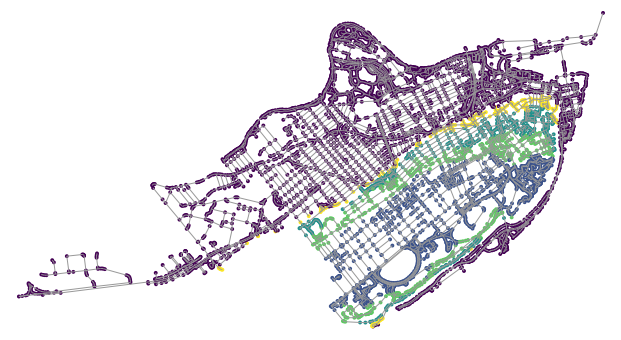

(<Figure size 1175.65x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f3d4e96f1d0>)

In [37]:
ox.plot_graph( graphQcAll5CC, node_color=nodeAssignCompleteV2)

In [38]:
complete_linkageWards= cluster.AgglomerativeClustering(
    linkage="ward",   
    n_clusters=5)

nodeAssignCompleteWard= complete_linkageWards.fit_predict(np.array(listElevsCC).reshape(-1,1))

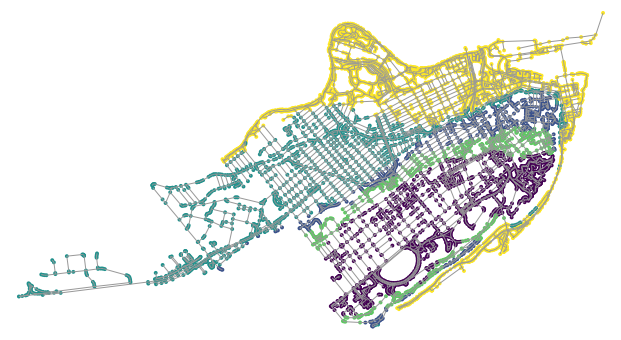

In [39]:
fig,ax=ox.plot_graph( graphQcAll5CC, node_color=nodeAssignCompleteWard)
fig.tight_layout()
fig.savefig(os.path.join(ROOT_DIR,"Figures","Clustering","wardElevClustering.png"))

In [40]:
complete_linkageWardV2= cluster.AgglomerativeClustering(
    linkage="ward",   
    n_clusters=5,
connectivity=adjMatrixQcAll5CC)

nodeAssignCompleteWardV2= complete_linkageWardV2.fit_predict(np.array(listElevsCC).reshape(-1,1))

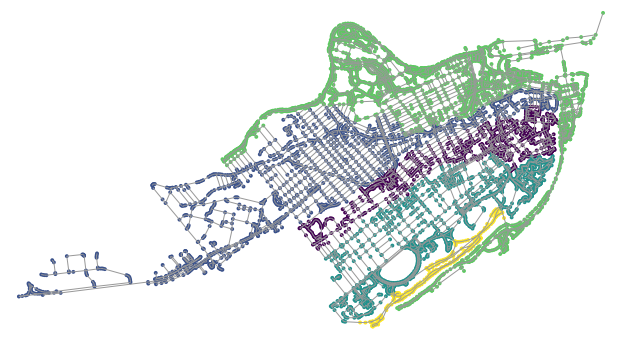

(<Figure size 1175.65x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f3d7f06d080>)

In [41]:
ox.plot_graph( graphQcAll5CC, node_color=nodeAssignCompleteWardV2)

In [42]:
####Try clustering on edge elevation now###

In [45]:
import scipy.special 
numEgeClusters=scipy.special.comb(5,2)
numEgeClusters

10.0

In [47]:
complete_linkageWardEdges= cluster.AgglomerativeClustering(
    linkage="ward",   
    n_clusters=5)

edgesAssignWard=complete_linkageWardEdges.fit_predict(dfAllEdges2['grade_abs'].values.reshape(-1,1))

edgesAssignWard[:4]

dfAllEdges2['edgeAssign'] = edgesAssignWard
dfAllEdges2.head()

startNode     endNode              startEndPair  grade_abs  edgeAssign
0  2510487581  2510487598  (2510487581, 2510487598)     0.0403           1
1  2510487581  2510487542  (2510487581, 2510487542)     0.0001           1
2  2510487598  2510487581  (2510487598, 2510487581)     0.0403           1
3  2510487598  2510487727  (2510487598, 2510487727)     0.0189           1
4  4247650351  6165020904  (4247650351, 6165020904)     0.0862           3

In [48]:
dfAllEdges2['edgeAssign'][2]

1

In [49]:
edgesAssignWardDict={(row['startNode'] ,row['endNode'] ) :  row['edgeAssign']  for i, row in dfAllEdges2.iterrows()}
list(edgesAssignWardDict)[:3]
#edgesAssignWardDict

[(2510487581, 2510487598), (2510487581, 2510487542), (2510487598, 2510487581)]

In [50]:
type(graphQcAll5CC)

networkx.classes.multigraph.MultiGraph

In [51]:
#nx.set_edge_attributes(graphQcAll5CC, edgesAssignWardDict, 'edgeAssign')
#[dat for u,v,dat in graphQcAll5CC.edges.data()]
counter=0
for u,v,dat in graphQcAll5CC.edges.data(True):
    dat['edgeAssign'] = dfAllEdges2['edgeAssign'][counter]
    counter+=1

In [52]:
[dat for u,v,dat in graphQcAll5CC.edges.data()][:2]

[{'highway': 'service',
  'length': 7.784,
  'oneway': False,
  'grade_abs': 0.0403,
  'grade': 0.0403,
  'service': 'alley',
  'osmid': 243670914,
  'edgeAssign': 1},
 {'highway': 'service',
  'length': 16.588,
  'oneway': False,
  'grade_abs': 0.0001,
  'grade': 0.0001,
  'service': 'alley',
  'osmid': 243670914,
  'edgeAssign': 1}]

In [53]:
dfAllEdges2['edgeAssign'].unique()

array([1, 3, 2, 0, 4])

In [54]:
#colEdges=ox.get_edge_colors_by_attr(graphQcAll5CC, attr='edgeAssign')
colEdges=getColGraphAttrEdges(graphQcAll5CC,
                     dfAllEdges2['edgeAssign'].unique(),
                     'edgeAssign', 
                     5)



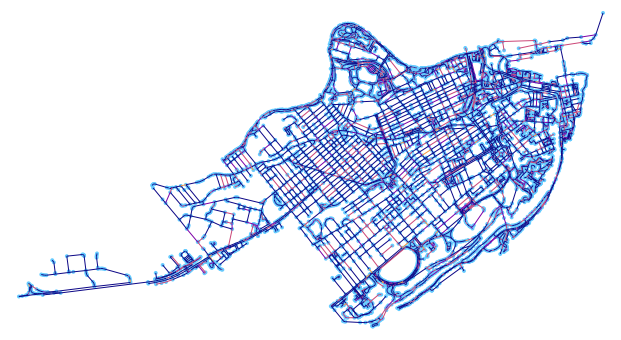

(<Figure size 1175.65x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f3d7e8fd9b0>)

In [55]:
ox.plot_graph( graphQcAll5CC, edge_color=colEdges)

In [56]:
#Plot the node eleves according to neigh and 

In [57]:
graphQcAll5CC=ox.add_edge_bearings(graphQcAll5CC)

In [58]:
dfEdgesCCNeigh=getAllListEdgesDirectedMultigraph(graphQcAll5CC, 
                                  listNeigh=listNeighAll5,
                                 listFeat=['grade_abs','bearing','edgeAssign'])

In [ ]:
dfEdgesCCNeigh=addNeighNamePairFromNeighIdxPair(dfEdgesCCNeigh).head()

In [ ]:
dfEdgesCCNeigh.head(6)

In [ ]:
dfEdgesCCNeigh['neighPairUndirected']= [ getNeighNamePairFromNeighIndexPair(i, useDirected=False) for i, row in dfEdgesCCNeigh.iterrows()  ]

In [ ]:
dfEdgesCCNeigh.head()

In [ ]:
===============================

In [ ]:
===============================

In [59]:
#Tests with cell colors

In [60]:
set(colEdges)

{(0.050383, 0.029803, 0.527975, 1.0),
 (0.494877, 0.01199, 0.657865, 1.0),
 (0.798216, 0.280197, 0.469538, 1.0),
 (0.973416, 0.585761, 0.25154, 1.0)}

In [61]:
dfCol=getColorCategorical( dfAllEdges2['edgeAssign']) 
dfCol

group                                                col
0      0  (0.8941176470588236, 0.10196078431372549, 0.10...
1      1  (0.21568627450980393, 0.49411764705882355, 0.7...
2      2  (0.30196078431372547, 0.6862745098039216, 0.29...
3      3  (0.596078431372549, 0.3058823529411765, 0.6392...
4      4                (1.0, 0.4980392156862745, 0.0, 1.0)

In [62]:
numDistCols=4
listInts= np.random.randint(100, 500, numDistCols)
cols=[plt.cm.Set1((i-100)/(500-100)) for i in listInts ]

In [63]:
plt.scatter(x=np.random.rand(numDistCols),
            y=np.random.rand(numDistCols), 
           s=np.random.randint(100, 500, numDistCols),
           c=cols)

In [64]:
plt.scatter(x=listInts,
            y=listInts, 
           c=cols)

In [65]:
plt.scatter(x=range(len(set(colEdges))),
            y=range(len(set(colEdges))),
            c=list(set(colEdges)) )

In [66]:
#Tests with networkx objects and working with edges

In [67]:
G=nx.Graph()
print(type(G))
G.add_edge(1,0,**{"a":1,"b":2})
G.add_edge(0,1,**{"a":3,"b":2})
[dat for u,dat in G.nodes.data()]
[(u,v,dat) for u,v,dat in G.edges.data()]

<class 'networkx.classes.graph.Graph'>


[(1, 0, {'a': 3, 'b': 2})]

In [68]:
print(G.has_edge(0,1), G.has_edge(1,0))

True True


In [69]:
re.search('.*(?<!Di)Graph.*', "{}".format(type(G)))

<re.Match object; span=(0, 38), match="<class 'networkx.classes.graph.Graph'>">

In [70]:
GDir=nx.DiGraph()
print(type(GDir))
GDir.add_edge(1,0,**{"a":1,"b":2})
GDir.add_edge(0,1,**{"a":3,"b":2})
[dat for u,dat in GDir.nodes.data()]
[(u,v,dat) for u,v,dat in GDir.edges.data()]

<class 'networkx.classes.digraph.DiGraph'>


[(1, 0, {'a': 1, 'b': 2}), (0, 1, {'a': 3, 'b': 2})]

In [71]:
print(GDir.has_edge(0,1), GDir.has_edge(1,0))

True True


In [72]:
print(re.search('.*(?<!Di)Graph.*', "{}".format(type(GDir))))
re.match('.*DiGraph.*', "{}".format(type(GDir)))

None


<re.Match object; span=(0, 42), match="<class 'networkx.classes.digraph.DiGraph'>">

In [ ]:
#Shitty erroneous tests

In [ ]:
graphQcAll5Undirected = graphQcAll5.to_undirected()

#Get the largest connected component
graphCC=getLargestConnectedComponent(graphQcAll5Undirected)

#Get the adjacency matrix
#If weightCol is None then will use the simple adj matrix
adjMatCC=getAdjMatrixFromGraph(graphCC,
                                 weightCol="grade_abs")

In [ ]:
adjMatCC[1:10,1:10]

In [ ]:
adjMatCC2=nx.adjacency_matrix(graphCC, weight='grade_abs')
print(adjMatCC2.shape)

In [ ]:
adjMatCC3=nx.adjacency_matrix(graphCC, weight=None)
print(adjMatCC3.shape)

In [ ]:
print(adjMatCC.shape)
len([i for i in graphCC.edges()])

In [ ]:

#For an undirected graph, (u,v) and (v,u) are the same and graph.has_edge((a,b)) = graph.as_edge((b,a))
graphCCSimple=nx.Graph()

#We will iterate over each (u,v) and (v,u)
for u,v,data in graphCC.edges(data=True):
    w = data['grade_abs'] if 'grade_abs' in data else 1.0
    if graphCCSimple.has_edge(u,v) :
        graphCCSimple[u][v]['grade_abs'] = max( graphCC[u][v]['grade_abs'], 
                                               w)
    else:
        graphCCSimple.add_edge(u, v)
        graphCCSimple[u][v]['grade_abs']=w

In [ ]:
len( [dat['grade_abs'] for u,v,dat in graphCC.edges.data()]  )

In [ ]:
len( [dat['grade_abs'] for u,v,dat in graphCCSimple.edges.data()]  )

In [ ]:
dfEdgesCC=getEdgesFromGraph(graphCC,['grade_abs'])
print(dfEdgesCC.shape)
dfEdgesCC.head()

In [ ]:
len(set(dfEdgesCC.Edge.values))

In [ ]:
dfEdgesCC['grade_abs'].values.reshape(-1, 1)

In [ ]:
nodeAssign = cluster.AgglomerativeClustering(
    linkage="average",   
    n_clusters=5,
    connectivity=adjMatCC).fit_predict(dfEdgesCC['grade_abs'].values.reshape(-1, 1))

In [ ]:
pd.DataFrame(nodeAssign)[0].value_counts()